# Purpose

We want to join the union membership data to the treated parishes in order to see if there was a different in union membership between treated and untreated parishes.

The union membership data come from "https://snd.gu.se/sv/catalogue/dataset/snd0209-1"

The treatment and control groups are derived from the spread of the Western Line across Sweden.

The outcome we want to see is whether there was a difference in union membership between treated and untreated parishes.

In [1]:
# import libraries
import pandas as pd
import matplotlib.pyplot as plt
from difflib import get_close_matches
from matplotlib.lines import Line2D

# set wd to C:\Users\User\Documents\Recon\paper-3-analysis
import os
os.chdir('C:\\Users\\User\\Documents\\Recon\\paper-3-analysis')

## Read in data and modify in order to merge

In [2]:
data_alternative = pd.read_excel("data/union-data/snd/0209total.xlsx")
parish_data = pd.read_excel("data/parishes/treated_parishes_with_distance_threshold_and_population.xlsx")

# Preprocess the 'parish_code' and 'parish_name' columns
parish_data['parish_code'] = parish_data['parish_code'].str.replace('SE/', '').astype(int)
parish_data['parish_name'] = parish_data['parish_name'].str.replace('församling', '').str.strip()

# Remove anything between and including brackets from the parish names
data_alternative['V10'] = data_alternative['V10'].str.replace(r'\(.*\)', '').str.strip()
parish_data['parish_name'] = parish_data['parish_name'].str.replace(r'\(.*\)', '').str.strip()

# Drop the last three digits from the 'parish_code' column
parish_data['parish_code'] = parish_data['parish_code'] // 1000


## Use parish name and parish code to merge

In [3]:
# Create a mapping from parish codes to parish names from the original dataset
code_to_names_original = data_alternative.groupby('V9')['V10'].apply(list).to_dict()

def find_closest_match(code, name):
    possible_matches = code_to_names_original.get(code, [])
    closest_matches = get_close_matches(name, possible_matches, n=1, cutoff=0.7)
    return closest_matches[0] if closest_matches else None

# Apply the function to find the closest match for each parish
parish_data['closest_match_name'] = parish_data.apply(lambda row: find_closest_match(row['parish_code'], row['parish_name']), axis=1)


## Merge and create column for plotting

In [4]:
# Merge matched data with the original dataset
matched_merged = pd.merge(parish_data, data_alternative, left_on=['parish_code', 'closest_match_name'], right_on=['V9', 'V10'])

# Define color based on 'treated' and 'distance_to_line' columns
def determine_color(row):
    if row['treated'] == 1:
        return 'orange'
    elif row['treated'] == 0 and row['distance_to_line'] < 250:
        return 'blue'
    else:
        return 'grey'

matched_merged['color'] = matched_merged.apply(determine_color, axis=1)


In [ ]:
# write matched_merged to disk at data/parishes/matched_merged.xlsx
# matched_merged.to_excel('data/parishes/union_membership_and_treated_groups_merged.xlsx', index=False)

## Rename columns to be more descriptive, from the original data repository on SND

In [8]:
import re

# Create a function to convert the variable names to snake_case
def to_snake_case(text):
    # Convert to lowercase and replace spaces with underscores
    s = re.sub(r'[\s\-]+', '_', text.lower())
    # Remove non-alphanumeric characters
    s = re.sub(r'[^\w_]', '', s)
    return s

# Create a mapping from V1, V2, ... V98 to the provided column names in snake_case
variable_names = [
    "SSD Study NR 0209",
    "SSD Edition NR 3",
    "SSD Part NR 001",
    "ID number",
    "County code",
    "Geographical code corrected",
    "Geographical code 2576 municipalities",
    "Town where the association is located",
    "Assembly code according to Statistics Sweden 1985",
    "Name of the municipality",
    "Municipality code according to Statistics Sweden 1985",
    "Municipality name",
    "County and district number",
    "District name",
    "Organization code",
    "Organization name",
    "Department or lodge number",
    "Type of organization in code",
    "Type of organization",
    "Matrix index 1",
    "Matrix index 2",
    "The number of years the association has existed",
    "First year the association exists",
    "Last year the association exists",
    "The association closed the first time from and including the year",
    "The association closed the first time up to and including the year",
    "The association closed the second time from the year",
    "The association closed the second time to and by year"
]

# add the repeated n_members_1881 to n_members_1950 in format "n_members_YYYY" to variable_names
for i in range(1881, 1951):
    variable_names.append(f"n_members_{i}")


column_mapping = {f"V{i+1}": to_snake_case(variable_names[i]) for i in range(len(variable_names))}
column_mapping

{'V1': 'ssd_study_nr_0209',
 'V2': 'ssd_edition_nr_3',
 'V3': 'ssd_part_nr_001',
 'V4': 'id_number',
 'V5': 'county_code',
 'V6': 'geographical_code_corrected',
 'V7': 'geographical_code_2576_municipalities',
 'V8': 'town_where_the_association_is_located',
 'V9': 'assembly_code_according_to_statistics_sweden_1985',
 'V10': 'name_of_the_municipality',
 'V11': 'municipality_code_according_to_statistics_sweden_1985',
 'V12': 'municipality_name',
 'V13': 'county_and_district_number',
 'V14': 'district_name',
 'V15': 'organization_code',
 'V16': 'organization_name',
 'V17': 'department_or_lodge_number',
 'V18': 'type_of_organization_in_code',
 'V19': 'type_of_organization',
 'V20': 'matrix_index_1',
 'V21': 'matrix_index_2',
 'V22': 'the_number_of_years_the_association_has_existed',
 'V23': 'first_year_the_association_exists',
 'V24': 'last_year_the_association_exists',
 'V25': 'the_association_closed_the_first_time_from_and_including_the_year',
 'V26': 'the_association_closed_the_first_tim

In [9]:
# Rename the columns in matched_merged with column_mapping, where the keys are the original column names and the values are the new column names
matched_merged.rename(columns=column_mapping, inplace=True)

In [13]:
# print all column names except those containing 'n_members'
for col in matched_merged.columns:
    if 'n_members' not in col:
        print(col)

parish_code
parish_name
treated
distance_to_line
touching_treated
control
population_1900
population_1910
population_1930
closest_match_name
ssd_study_nr_0209
ssd_edition_nr_3
ssd_part_nr_001
id_number
county_code
geographical_code_corrected
geographical_code_2576_municipalities
town_where_the_association_is_located
assembly_code_according_to_statistics_sweden_1985
name_of_the_municipality
municipality_code_according_to_statistics_sweden_1985
municipality_name
county_and_district_number
district_name
organization_code
organization_name
department_or_lodge_number
type_of_organization_in_code
type_of_organization
matrix_index_1
matrix_index_2
the_number_of_years_the_association_has_existed
first_year_the_association_exists
last_year_the_association_exists
the_association_closed_the_first_time_from_and_including_the_year
the_association_closed_the_first_time_up_to_and_including_the_year
the_association_closed_the_second_time_from_the_year
the_association_closed_the_second_time_to_and_by_y

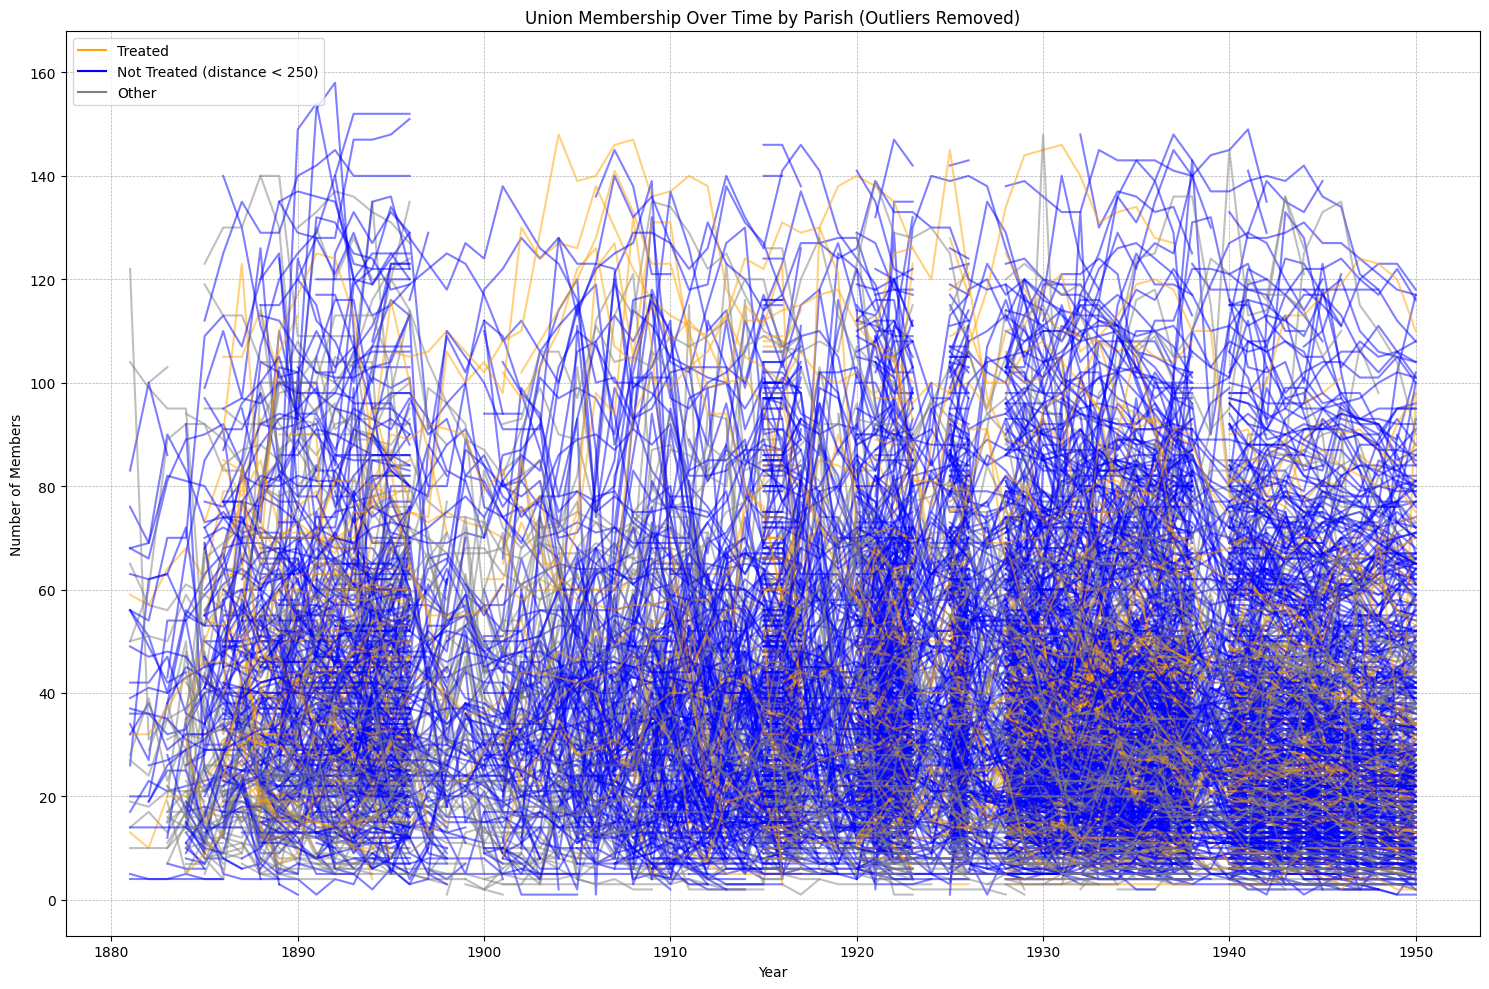

In [15]:
# membership columns contain the number of members for each year in format "n_members_YYYY"
membership_columns = [col for col in matched_merged.columns if 'n_members' in col]


# Removing outliers: Considering data points that fall beyond 1.5 times the interquartile range as outliers
Q1 = matched_merged[membership_columns].quantile(0.25)
Q3 = matched_merged[membership_columns].quantile(0.75)
IQR = Q3 - Q1

# Filter out rows where any of the membership columns contain outliers
filtered_data = matched_merged[~((matched_merged[membership_columns] < (Q1 - 1.5 * IQR)) | 
                                (matched_merged[membership_columns] > (Q3 + 1.5 * IQR))).any(axis=1)]

# Plotting the graph with adjusted x-axis labels
plt.figure(figsize=(15, 10))

# Generate x-axis labels as actual years
years = list(range(1881, 1881 + len(membership_columns)))

legend_elements = [Line2D([0], [0], color='orange', label='Treated'),
                   Line2D([0], [0], color='blue', label='Not Treated (distance < 250)'),
                   Line2D([0], [0], color='grey', label='Other')]

for _, group_data in filtered_data.groupby(['parish_code', 'color']):
    plt.plot(years, group_data[membership_columns].values[0], color=group_data['color'].values[0], alpha=0.5)

plt.legend(handles=legend_elements, loc='upper left')
plt.title('Union Membership Over Time by Parish (Outliers Removed)')
plt.xlabel('Year')
plt.ylabel('Number of Members')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()



In [19]:
# Extract pre-treatment and post-treatment years based on the given year, membership columns contain the number of members for each year in format "n_members_YYYY"
pre_treatment_years = [col for col in membership_columns if int(col.split('_')[2]) < 1921]
post_treatment_years = [col for col in membership_columns if int(col.split('_')[2]) >= 1921]

# Function to compute average growth rate
def compute_growth_rate(data, years):
    initial_year = data[years[0]]
    final_year = data[years[-1]]
    num_years = len(years)
    return (final_year - initial_year) / initial_year / num_years

# Compute average growth rates for both periods and both groups
avg_growth_pre_treated = matched_merged[matched_merged['treated'] == 1].apply(compute_growth_rate, years=pre_treatment_years, axis=1).mean()
avg_growth_post_treated = matched_merged[matched_merged['treated'] == 1].apply(compute_growth_rate, years=post_treatment_years, axis=1).mean()

avg_growth_pre_control = matched_merged[(matched_merged['treated'] == 0) & (matched_merged['distance_to_line'] < 250)].apply(compute_growth_rate, years=pre_treatment_years, axis=1).mean()
avg_growth_post_control = matched_merged[(matched_merged['treated'] == 0) & (matched_merged['distance_to_line'] < 250)].apply(compute_growth_rate, years=post_treatment_years, axis=1).mean()

# Calculate the DiD estimator
DiD = (avg_growth_post_treated - avg_growth_pre_treated) - (avg_growth_post_control - avg_growth_pre_control)
DiD


-0.020801705951549752

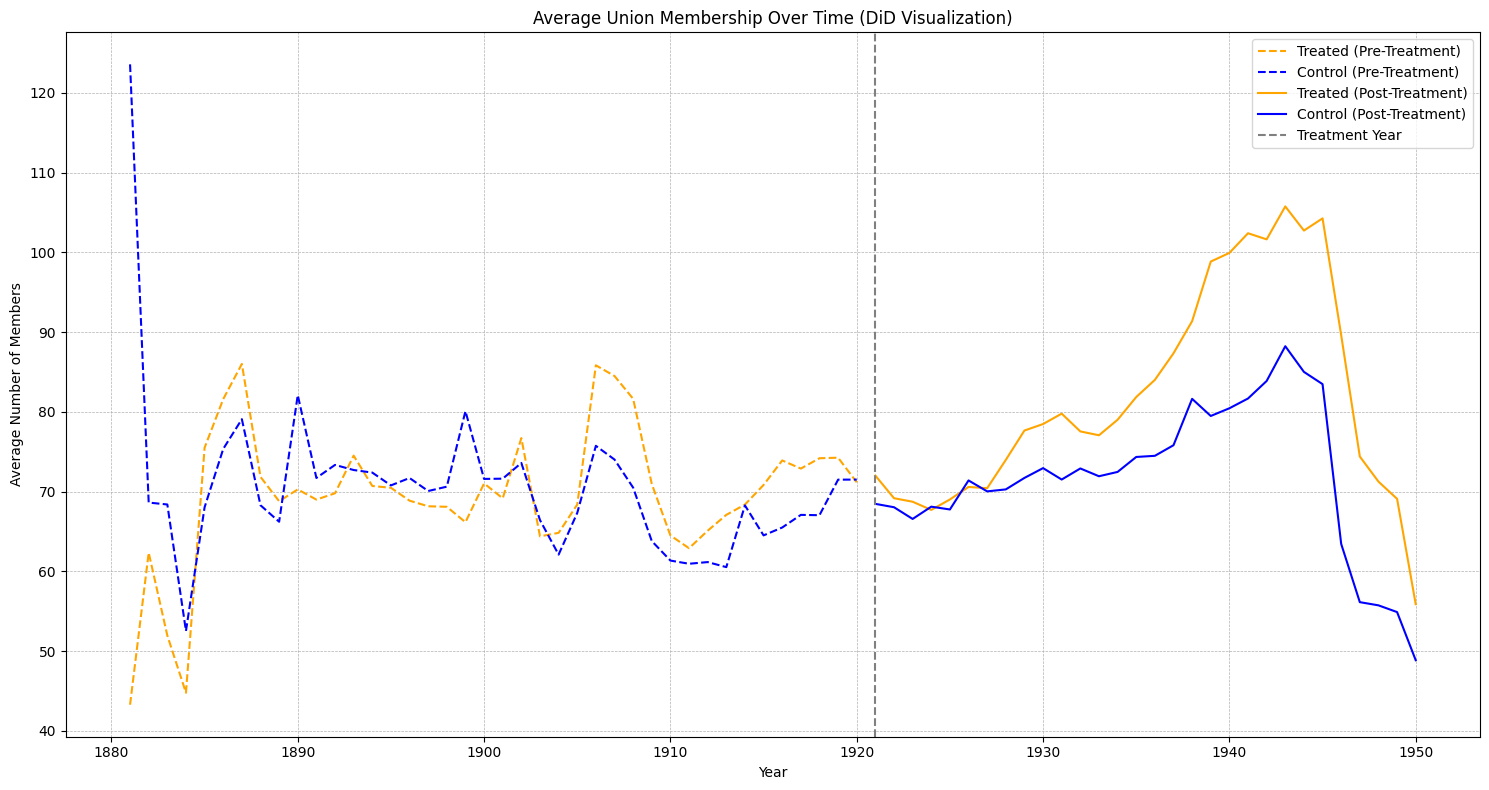

In [20]:
# Calculate average membership over time for treatment and control groups
avg_membership_treatment_pre = matched_merged[matched_merged['treated'] == 1][pre_treatment_years].mean(axis=0)
avg_membership_treatment_post = matched_merged[matched_merged['treated'] == 1][post_treatment_years].mean(axis=0)

avg_membership_control_pre = matched_merged[(matched_merged['treated'] == 0) & (matched_merged['distance_to_line'] < 250)][pre_treatment_years].mean(axis=0)
avg_membership_control_post = matched_merged[(matched_merged['treated'] == 0) & (matched_merged['distance_to_line'] < 250)][post_treatment_years].mean(axis=0)

# Plotting
plt.figure(figsize=(15, 8))
plt.plot(years[:len(pre_treatment_years)], avg_membership_treatment_pre, label='Treated (Pre-Treatment)', color='orange', linestyle='--')
plt.plot(years[:len(pre_treatment_years)], avg_membership_control_pre, label='Control (Pre-Treatment)', color='blue', linestyle='--')

plt.plot(years[len(pre_treatment_years):], avg_membership_treatment_post, label='Treated (Post-Treatment)', color='orange')
plt.plot(years[len(pre_treatment_years):], avg_membership_control_post, label='Control (Post-Treatment)', color='blue')

# Mark the treatment year with a dashed line
plt.axvline(x=1921, color='grey', linestyle='--', label='Treatment Year')

plt.title('Average Union Membership Over Time (DiD Visualization)')
plt.xlabel('Year')
plt.ylabel('Average Number of Members')
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()


In [39]:
# Filter data by treatment and control groups
treated_data = matched_merged[matched_merged['treated'] == 1]
control_data = matched_merged[(matched_merged['treated'] == 0) & (matched_merged['distance_to_line'] < 250)]

years = list(range(1890, 1946))
membership_columns = [f"n_members_{year}" for year in years]

# Calculate average union membership for each year, for both groups, where you group by code_type_of_organization and filter years between 1890 and 1945
treated_means = treated_data.groupby('type_of_organization_in_code')[membership_columns].mean().mean(axis=0)
control_means = control_data.groupby('type_of_organization_in_code')[membership_columns].mean().mean(axis=0)

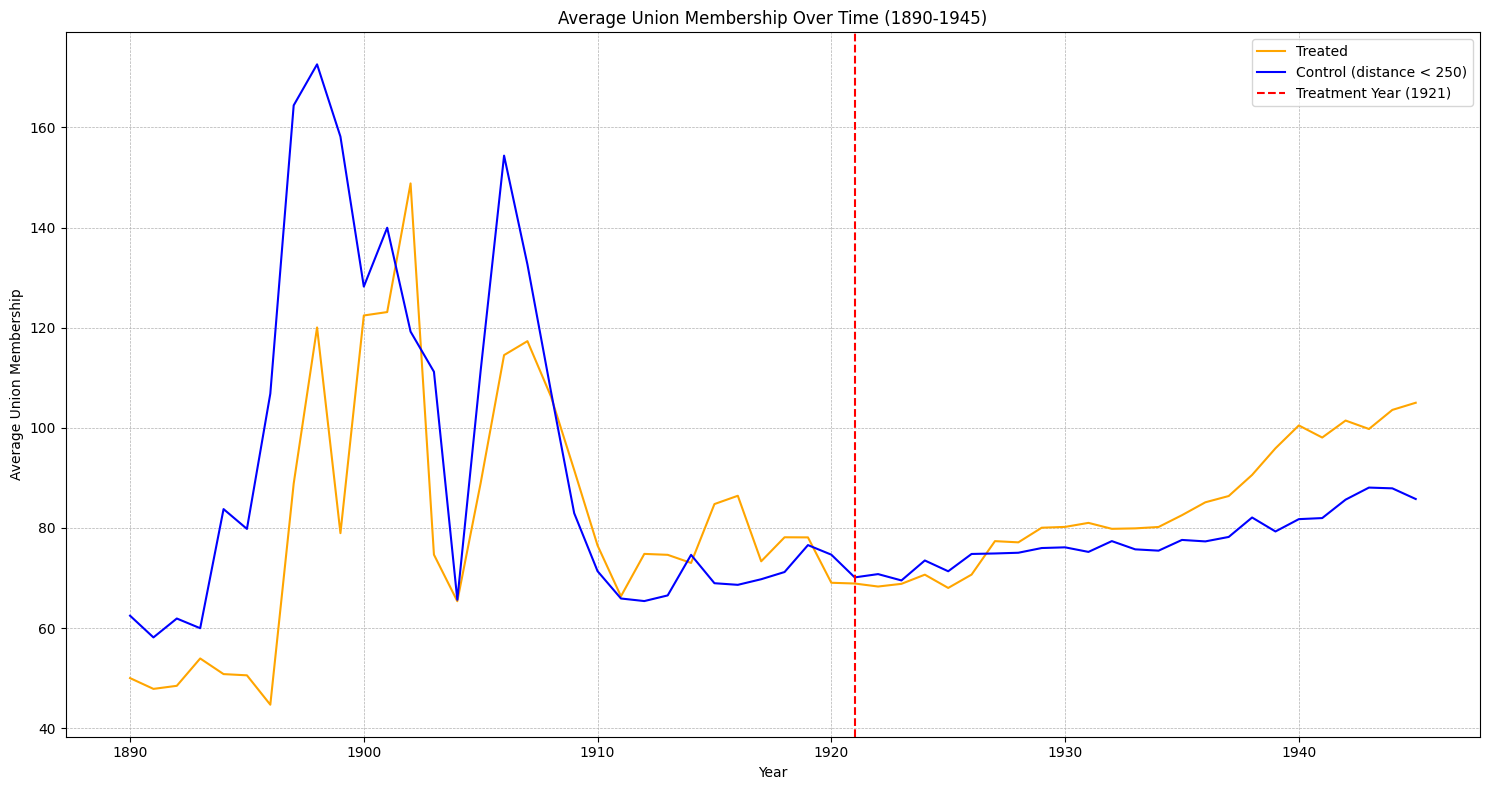

In [38]:
plt.figure(figsize=(15, 8))
plt.plot(years, treated_means, label='Treated', color='orange')
plt.plot(years, control_means, label='Control (distance < 250)', color='blue')
plt.axvline(x=1921, color='red', linestyle='--', label='Treatment Year (1921)')
plt.title('Average Union Membership Over Time (1890-1945)')
plt.xlabel('Year')
plt.ylabel('Average Union Membership')
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()
